In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import matplotlib.pyplot as plt
import yaml
from models.model2 import BicycleModel
from models.model4 import FourWheelModel
from models.utils import get_csv_row_count
from models.utils import get_folder_path
from models.utils import fit_circle
from models.utils import plot_column_histograms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def objective_function(x):
    return x[0]**2 + x[1]**2

num_particles = 50
max_iterations = 100
lower_bounds = [-1, -1]  # Lower bounds for x and y
upper_bounds = [1, 1]    # Upper bounds for x and y

particle_positions = np.random.uniform(lower_bounds, upper_bounds, (num_particles, 2))
particle_velocities = np.zeros((num_particles, 2))
best_particle_positions = particle_positions.copy()
global_best_position = best_particle_positions[np.argmin([objective_function(p) for p in particle_positions])]
particle_positions_history = []
particle_fitness_history = []

for _ in range(max_iterations):
    particle_positions_history.append(particle_positions.copy())
    particle_fitness_history.append([objective_function(p) for p in particle_positions])

    for i in range(num_particles):
        inertia = 0.5
        cognitive_rate = 0.5
        social_rate = 0.5
        r1, r2 = np.random.rand(2)
        cognitive_component = cognitive_rate * r1 * (best_particle_positions[i] - particle_positions[i])
        social_component = social_rate * r2 * (global_best_position - particle_positions[i])
        particle_velocities[i] = inertia * particle_velocities[i] + cognitive_component + social_component

        particle_positions[i] += particle_velocities[i]
        particle_positions[i] = np.clip(particle_positions[i], lower_bounds, upper_bounds)

        if objective_function(particle_positions[i]) < objective_function(best_particle_positions[i]):
            best_particle_positions[i] = particle_positions[i]

        if objective_function(best_particle_positions[i]) < objective_function(global_best_position):
            global_best_position = best_particle_positions[i]



fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot histogram at the start
ax1.hist2d(particle_positions_history[0][:, 0], particle_positions_history[0][:, 1], bins=20, cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Start of Optimization')

# Plot histogram at the middle
middle_index = len(particle_positions_history) // 2
ax2.hist2d(particle_positions_history[middle_index][:, 0], particle_positions_history[middle_index][:, 1], bins=20, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Middle of Optimization')

# Plot histogram at the end
ax3.hist2d(particle_positions_history[-1][:, 0], particle_positions_history[-1][:, 1], bins=20, cmap='viridis')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('End of Optimization')

plt.tight_layout()
plt.show()


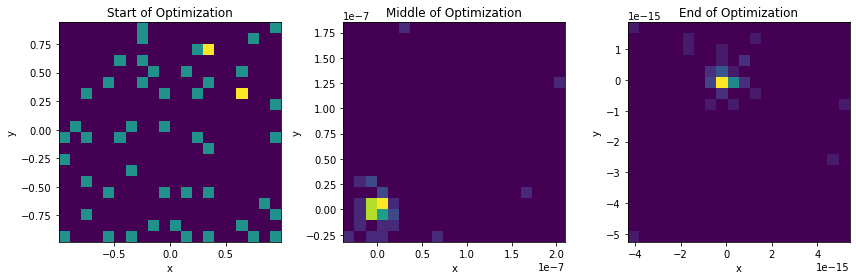

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot histogram at the start
ax1.hist2d(particle_positions_history[0][:, 0], particle_positions_history[0][:, 1], bins=20, cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Start of Optimization')

# Plot histogram at the middle
middle_index = len(particle_positions_history) // 2
ax2.hist2d(particle_positions_history[middle_index][:, 0], particle_positions_history[middle_index][:, 1], bins=20, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Middle of Optimization')

# Plot histogram at the end
ax3.hist2d(particle_positions_history[-1][:, 0], particle_positions_history[-1][:, 1], bins=20, cmap='viridis')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title('End of Optimization')

plt.tight_layout()
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot histogram at the start
ax1.hist(particle_fitness_history[0], bins=20, color='blue', edgecolor='black')
ax1.set_xlabel('Fitness')
ax1.set_ylabel('Count')
ax1.set_title('Start of Optimization')

# Plot histogram at the middle
middle_index = len(particle_fitness_history) // 2
ax2.hist(particle_fitness_history[middle_index], bins=20, color='green', edgecolor='black')
ax2.set_xlabel('Fitness')
ax2.set_ylabel('Count')
ax2.set_title('Middle of Optimization')

# Plot histogram at the end
ax3.hist(particle_fitness_history[-1], bins=20, color='red', edgecolor='black')
ax3.set_xlabel('Fitness')
ax3.set_ylabel('Count')
ax3.set_title('End of Optimization')

plt.tight_layout()
plt.show()

def update_plot(frame):
    plt.cla()
    plt.plot(*zip(*particle_positions_history[frame]), 'go', markersize=6)
    plt.contourf(X, Y, Z, levels=np.linspace(0, 100, 50), cmap='viridis')
    plt.xlabel('x')
    plt.ylabel('y')

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = X**2 + Y**2

fig = plt.figure()
ani = FuncAnimation(fig, update_plot, frames=len(particle_positions_history), interval=200)
plt.show()

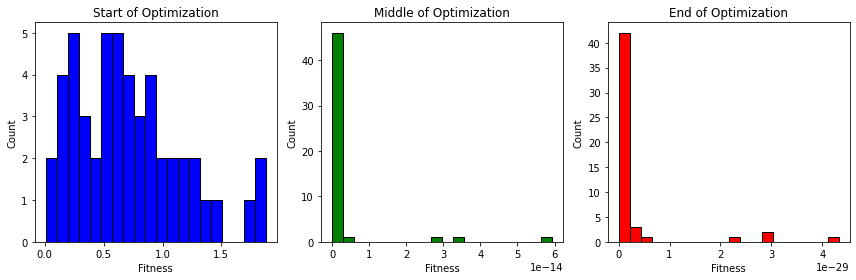

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Plot histogram at the start
ax1.hist(particle_fitness_history[0], bins=20, color='blue', edgecolor='black')
ax1.set_xlabel('Fitness')
ax1.set_ylabel('Count')
ax1.set_title('Start of Optimization')

# Plot histogram at the middle
middle_index = len(particle_fitness_history) // 2
ax2.hist(particle_fitness_history[middle_index], bins=20, color='green', edgecolor='black')
ax2.set_xlabel('Fitness')
ax2.set_ylabel('Count')
ax2.set_title('Middle of Optimization')

# Plot histogram at the end
ax3.hist(particle_fitness_history[-1], bins=20, color='red', edgecolor='black')
ax3.set_xlabel('Fitness')
ax3.set_ylabel('Count')
ax3.set_title('End of Optimization')

plt.tight_layout()
plt.show()

In [ ]:
def update_plot(frame):
    plt.cla()
    plt.plot(*zip(*particle_positions_history[frame]), 'go', markersize=6)
    plt.contourf(X, Y, Z, levels=np.linspace(0, 100, 50), cmap='viridis')
    plt.xlabel('x')
    plt.ylabel('y')

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = X**2 + Y**2

fig = plt.figure()
ani = FuncAnimation(fig, update_plot, frames=len(particle_positions_history), interval=200)
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class Particle:
    def __init__(self, position, velocity):
        self.position = position
        self.velocity = velocity
        self.best_position = position

    def update_velocity(self, inertia, cognitive_rate, social_rate, global_best_position):
        r1, r2 = np.random.rand(2)
        cognitive_component = cognitive_rate * r1 * (self.best_position - self.position)
        social_component = social_rate * r2 * (global_best_position - self.position)
        self.velocity = inertia * self.velocity + cognitive_component + social_component

    def update_position(self, lower_bounds, upper_bounds):
        self.position += self.velocity
        self.position = np.clip(self.position, lower_bounds, upper_bounds)

    def update_best_position(self, objective_function):
        if objective_function(self.position) < objective_function(self.best_position):
            self.best_position = self.position


class PSO:
    def __init__(self, num_particles, max_iterations, lower_bounds, upper_bounds):
        self.num_particles = num_particles
        self.max_iterations = max_iterations
        self.lower_bounds = lower_bounds
        self.upper_bounds = upper_bounds
        self.particles = []
        self.global_best_position = None
        self.particle_positions_history = []
        self.particle_fitness_history = []

    def optimize(self, objective_function, inertia=0.5, cognitive_rate=0.5, social_rate=0.5):
        self.initialize_particles()

        for _ in range(self.max_iterations):
            self.particle_positions_history.append([particle.position for particle in self.particles])
            self.particle_fitness_history.append([objective_function(particle.position) for particle in self.particles])

            for particle in self.particles:
                particle.update_velocity(inertia, cognitive_rate, social_rate, self.global_best_position)
                particle.update_position(self.lower_bounds, self.upper_bounds)
                particle.update_best_position(objective_function)

            self.update_global_best_position(objective_function)

    def initialize_particles(self):
        self.particles = []
        for _ in range(self.num_particles):
            position = np.random.uniform(self.lower_bounds, self.upper_bounds)
            velocity = np.zeros_like(position)
            particle = Particle(position, velocity)
            self.particles.append(particle)

        self.global_best_position = self.particles[np.argmin([objective_function(particle.position) for particle in self.particles])].position

    def update_global_best_position(self, objective_function):
        for particle in self.particles:
            if objective_function(particle.position) < objective_function(self.global_best_position):
                self.global_best_position = particle.position

    def plot_particle_positions(self, frame):
        plt.cla()
        plt.plot(*zip(*self.particle_positions_history[frame]), 'go', markersize=6)
        plt.contourf(self.X, self.Y, self.Z, levels=np.linspace(0, 100, 50), cmap='viridis')
        plt.xlabel('x')
        plt.ylabel('y')

    def plot_particle_fitness_history(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

        # Plot histogram at the start
        ax1.hist(self.particle_fitness_history[0], bins=20, color='blue', edgecolor='black')
        ax1.set_xlabel('Fitness')
        ax1.set_ylabel('Count')
        ax1.set_title('Start of Optimization')

        # Plot histogram at the middle
        middle_index = len(self.particle_fitness_history) // 2
        ax2.hist(self.particle_fitness_history[middle_index], bins=20, color='green', edgecolor='black')
        ax2.set_xlabel('Fitness')
        ax2.set_ylabel('Count')
        ax2.set_title('Middle of Optimization')

        # Plot histogram at the end
        ax3.hist(self.particle_fitness_history[-1], bins=20, color='red', edgecolor='black')
        ax3.set_xlabel('Fitness')
        ax3.set_ylabel('Count')
        ax3.set_title('End of Optimization')

        plt.tight_layout()
        plt.show()
    def plot_particle_history(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
        # Plot histogram at the start
        ax1.hist2d(particle_positions_history[0][:, 0], particle_positions_history[0][:, 1], bins=20, cmap='viridis')
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_title('Start of Optimization')

        # Plot histogram at the middle
        middle_index = len(particle_positions_history) // 2
        ax2.hist2d(particle_positions_history[middle_index][:, 0], particle_positions_history[middle_index][:, 1], bins=20, cmap='viridis')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_title('Middle of Optimization')

        # Plot histogram at the end
        ax3.hist2d(particle_positions_history[-1][:, 0], particle_positions_history[-1][:, 1], bins=20, cmap='viridis')
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')
        ax3.set_title('End of Optimization')

        plt.tight_layout()
        plt.show()

    def plot_particle_positions_animate(self):
        self.X, self.Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
        self.Z = self.X**2 + self.Y**2

        fig = plt.figure()
        ani = FuncAnimation(fig, self.plot_particle_positions, frames=len(self.particle_positions_history), interval=200)
        plt.show()


# Example usage
pso = PSO(num_particles=100, max_iterations=1000, lower_bounds=[-10, -10], upper_bounds=[10, 10])

def objective_function(x):
    return x[0]**2 + x[1]**2

pso.optimize(objective_function)
pso.plot_particle_history()
pso.plot_particle_fitness_history()
#pso.plot_particle_positions_history()
